                                            SPEECH RECOGNITION

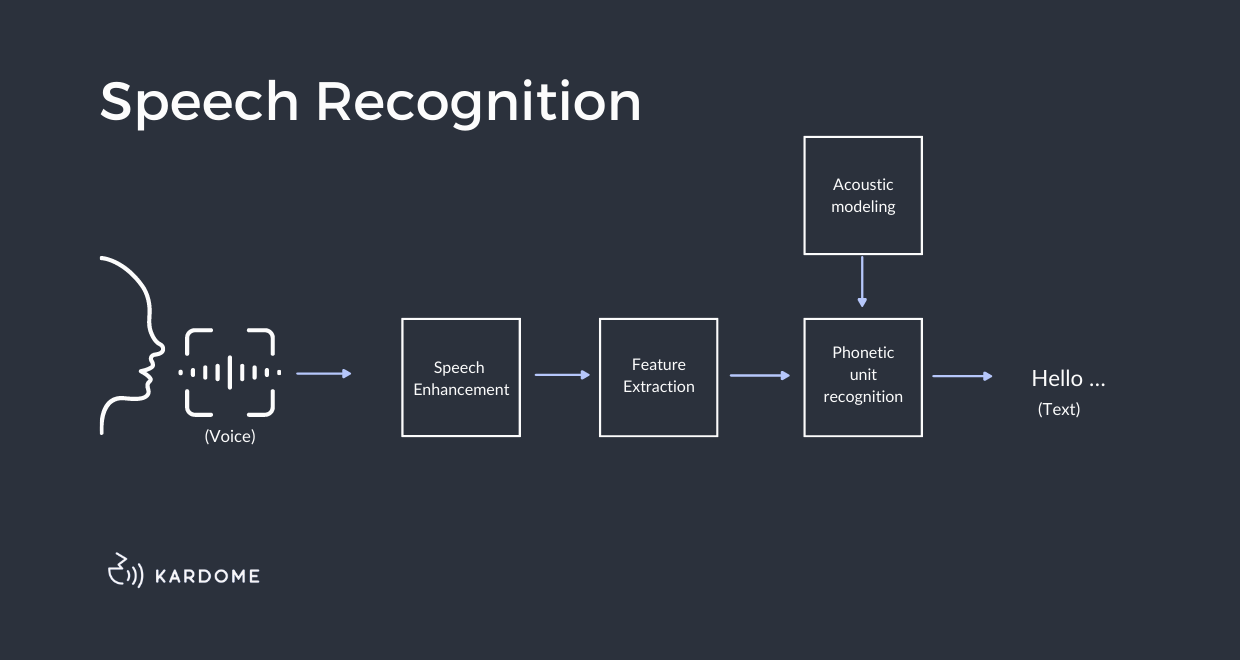

What is Speech Recognition:

Speech recognition, also known as automatic speech recognition (ASR) or voice recognition, is a technology that converts spoken language into written text. 

Here are the key steps in a short summary:

Acquisition of Audio Input: Capture audio signals using a microphone or other recording device.

Preprocessing: Clean and preprocess the audio data to enhance signal quality, removing noise or distortions.

Feature Extraction: Extract relevant features from the audio signal, such as spectral features or Mel-frequency cepstral coefficients (MFCCs).

Model Training: Train a speech recognition model using machine learning algorithms, often deep neural networks, on a labeled dataset containing pairs of audio samples and their corresponding transcriptions.

Decoding: Apply the trained model to decode or transcribe the input audio into text.

Post-processing: Refine the transcription results, applying techniques such as language modeling or context-aware algorithms.

Output: Obtain the final transcribed text as the output of the speech recognition system.

Speech recognition is used in various applications, including voice assistants, transcription services, and hands-free operation of devices.

## INTRODUCTION

WHAT WE WILL COVER IN THIS PROJECT:

1) Speech Recognition-speech to text, text to speech and translation:

    a) Capture spoken audio and display the transcription(predicted text)
    
    b) Enrich audio by volume and background nosie adjustments
    
    c) Compare transcription to actual text.Utilize WER score.
    
    d) Translate the transcribed text into another language(French and Turkish).
    
    e) Listen to the audio of translated text
    
2) Speech Recognition-prediction of gender from audio files:

    a) Visualize audio files for key indicators for gender recognition.
    
    b) Extract key features from audio files to input into model training.
    
    c) Train and evaluate a neural network model to predict the gender for audio files.
    
    
We are provided with many short audio files to be used for this project. For our translation section, we will only use handful of these files to showcase and for gender prediction, we will be using a subset(10,000) of the training data that is provided. A separate csv file is provided that has the audio file names, actual spoken text, gender, age of speaker and few other datapoints to assist with the project.

## Part 1 - Speech to text, text to speech and translation

Importing libraries and the csv file

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
# Specify the file path
file_path = '/kaggle/input/common-voice/cv-valid-train.csv'

# Read the CSV file into a DataFrame
dftrain = pd.read_csv(file_path)
dftrain.info()

There are many blanks on few of the columns, for predicting gender, we will only use the rows that have the data.

In [ ]:
# Set the option to display maximum column width
pd.set_option('display.max_colwidth', None)
dftrain.head()

Lets listen to the first 10 audio files in our training folder. We obserbe that some file have very low volume along with background noise which will be challenging to perfrom speech to text tasks. Click play to play the audio.

In [ ]:
from IPython.display import display, Audio
import os
from pydub import AudioSegment

# Function to play audio file
def play_audio(audio_path):
    display(Audio(filename=audio_path))

# Specify the folder path containing MP3 files
folder_path = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'

# Get the list of all files in the folder and sort them
all_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.mp3')])

# Get the total file count
total_files = len(all_files)
print(f'Total number of MP3 files in the folder: {total_files}')

# Play the first two audio files
for i in range(min(10, len(all_files))):
    file_path = os.path.join(folder_path, all_files[i])
    audio = AudioSegment.from_mp3(file_path)
    
    print(f'Playing file: {all_files[i]}')
    play_audio(file_path)

In [ ]:
!pip install SpeechRecognition pydub

Performing speech to text on first 10 audio files. As a baseline, we see that SpeechRecognition library does a decent job. We will try to improve by applying extra adjustments on audio files.

In [ ]:
import os
import speech_recognition as sr
from pydub import AudioSegment

# Set the path to the audio files
audio_folder = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'

# Get a list of all audio files in the folder
audio_files = [file for file in os.listdir(audio_folder) if file.endswith('.mp3')]

# Sort the audio files
audio_files.sort()

# Take the first 10 audio files
selected_audio_files = audio_files[:10]

# Initialize the recognizer
recognizer = sr.Recognizer()

# Process each selected audio file
for audio_file in selected_audio_files:
    # Load the audio file
    audio_path = os.path.join(audio_folder, audio_file)
    audio = AudioSegment.from_mp3(audio_path)

    # Convert the audio to WAV format (required by SpeechRecognition)
    audio.export("temp.wav", format="wav")

    # Recognize speech using Google Web Speech API
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        try:
            # Perform speech recognition
            text = recognizer.recognize_google(audio_data)
            print(f"Audio File: {audio_file}\nTranscription: {text}\n")
        except sr.UnknownValueError:
            print(f"Audio File: {audio_file}\nTranscription not recognized\n")
        except sr.RequestError as e:
            print(f"Audio File: {audio_file}\nError with the speech recognition service; {e}\n")

# Clean up the temporary WAV file
os.remove("temp.wav")

## Data Clean up - Volume and Background Adjustments

We are now trying to adjust the volume of all files and reduce background noise where applicable in order to improve our recognition quality. Sound file adjustment is a complicated process and in some cases it can reduce the actual length of the files, when that happens we may lose some of the audio when performing speech to text so we are also padding all files after the adjustments by 2 seconds. 

Parameters used in noise reduction function:

silence_threshold: This parameter represents the level below which a segment of the audio is considered as silence. Audio portions with levels below this threshold might be treated as silent and potentially removed.

keep_silence: This parameter represents the duration of silence to keep. If there are silent portions in the audio below the silence_threshold, they might be removed unless they are longer than the duration specified by keep_silence.

In [ ]:
import os
from pydub import AudioSegment, silence
from concurrent.futures import ThreadPoolExecutor
from pydub.playback import play

# Function to adjust volume and remove background noise
def process_audio(file_path, reference_audio):
    # Load original audio
    original_audio = AudioSegment.from_mp3(file_path)
    
    # Adjust volume
    adjusted_audio = original_audio.apply_gain(reference_audio.dBFS - original_audio.dBFS)
    
    # Remove background noise
    adjusted_audio = remove_background_noise(adjusted_audio)
    
    # Trim or pad to match the length of the original audio with an extra 2 seconds
    adjusted_audio = match_audio_length(original_audio, adjusted_audio, extra_padding=2000)
    
    return adjusted_audio

# Function to remove background noise
def remove_background_noise(audio, silence_threshold=-30, keep_silence=100):
    # Split audio on silence and filter out silent chunks
    chunks = silence.split_on_silence(audio, silence_thresh=silence_threshold, keep_silence=keep_silence)
    filtered_audio = AudioSegment.silent()
    for chunk in chunks:
        filtered_audio += chunk

    return filtered_audio

# Function to match the length of two audio segments
def match_audio_length(original_audio, adjusted_audio, extra_padding=0):
    # Calculate the target length with extra padding
    target_length = len(original_audio) + extra_padding

    # Trim or pad to match the target length
    if len(adjusted_audio) < target_length:
        adjusted_audio = adjusted_audio + AudioSegment.silent(duration=target_length - len(adjusted_audio))
    elif len(adjusted_audio) > target_length:
        adjusted_audio = adjusted_audio[:target_length]

    return adjusted_audio

# Specify the folder path containing MP3 files
folder_path = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'

# Specify the reference file for volume adjustment
reference_file = 'sample-000000.mp3'
reference_file_path = os.path.join(folder_path, reference_file)
reference_audio = AudioSegment.from_mp3(reference_file_path)

# Process only the first 10 audio files
audio_files = [file for file in os.listdir(folder_path) if file.endswith('.mp3')]
audio_files.sort()
selected_audio_files = audio_files[:10]

# Counter for tracking the number of files being processed
files_processed_counter = 0

# Process audio files (adjust volume and remove background noise) using parallelization
with ThreadPoolExecutor() as executor:
    # List of futures representing the ongoing audio processing tasks
    futures_process = []

    for file_name in selected_audio_files:
        file_path = os.path.join(folder_path, file_name)

        # Process audio (adjust volume and remove background noise)
        futures_process.append(executor.submit(process_audio, file_path, reference_audio))
        files_processed_counter += 1
        print(f'\rProcessing audio: {files_processed_counter} files processed', end='', flush=True)

    # Wait for all audio processing tasks to complete and retrieve results
    processed_audios = [future.result() for future in futures_process]

# Print the names of the processed audio files
print("\nNames of processed audio files:")
for i, file_name in enumerate(selected_audio_files):
    print(f"{i + 1}. {file_name}")


Play the adjusted files, these are the same 10 files we listened earlier but now adjusted for volume and background noise. We observe that quality is much improved.

In [ ]:
from IPython.display import Audio, display

# Specify the folder path to save the processed audio files
output_folder = '/kaggle/working/'

# Save the processed audio files with the same names
for i, audio in enumerate(processed_audios):
    file_name, file_extension = os.path.splitext(selected_audio_files[i])
    output_file_path = os.path.join(output_folder, f'{file_name}.mp3')
    audio.export(output_file_path, format='mp3')

    print(f'Saved processed audio: {output_file_path}')

    # Play the processed audio
    print(f'Playing Adjusted Audio: {selected_audio_files[i]}')
    display(Audio(output_file_path))

## COMPARISON

We now compare the transcribed(predicted) text from our SpeechRecognition library vs the actual text that is already available on the provided csv file. We use WER scoring to evaluate the predcited text vs the actual text.

WER, or Word Error Rate, is a metric commonly used to evaluate the performance of automatic speech recognition (ASR) systems, machine translation systems, and other systems involving the conversion of spoken or written language. WER is a measure of the percentage of words that are incorrectly predicted or transcribed by the system. Lower the WER score, the better the speech to text task.

We observe that our Speech to Text performance is pretty good based on below.

In [ ]:
!pip install SpeechRecognition pydub python-Levenshtein

In [ ]:
import os
import pandas as pd
import speech_recognition as sr
import Levenshtein as lev
from pydub import AudioSegment
from pydub.effects import normalize

# Set the path to the audio files
csv_path = '/kaggle/input/common-voice/cv-valid-train.csv'

# Read the CSV file
df = pd.read_csv(csv_path)

# Use the processed audio files generated in the previous code
#processed_audios = [AudioSegment.from_mp3(file) for file in os.listdir('/kaggle/working') if file.startswith('processed_audio')]

# Take the first 10 processed audio files
selected_processed_audios = processed_audios[:10]

# Initialize the recognizer
recognizer = sr.Recognizer()

for i, audio in enumerate(selected_processed_audios):
    # Apply volume adjustment
    audio = normalize(audio)

    # Export the processed audio to a temporary WAV file
    audio.export("temp.wav", format="wav")

    # Retrieve actual text from the CSV based on filename
    filename_from_text = f'sample-{i:06d}.mp3'
    actual_text = df[df['filename'].str.split('/').str[-1] == filename_from_text]['text'].values


    if len(actual_text) > 0:
        actual_text = actual_text[0]

        # Recognize speech using Google Web Speech API
        with sr.AudioFile("temp.wav") as source:
            audio_data = recognizer.record(source)
            try:
                # Perform speech recognition
                text = recognizer.recognize_google(audio_data)
                # Calculate WER score
                wer_score = lev.distance(text.split(), actual_text.split()) / len(actual_text.split())

                # Print results
                print(f"Filename: {filename_from_text}")
                print(f"Predicted Text: {text}")
                print(f"Actual Text: {actual_text}")
                print(f"WER Score: {wer_score}\n")
            except sr.UnknownValueError:
                print(f"Audio File: {filename_from_text}\nTranscription not recognized\n")
            except sr.RequestError as e:
                print(f"Audio File: {filename_from_text}\nError with the speech recognition service; {e}\n")
    else:
        print(f"Actual text not found in CSV file for {filename_from_text}\n")

# Clean up the temporary WAV file
os.remove("temp.wav")


## TRANSLATION

We will now attempt to translate the transcribed text into two other laguages and will view the transcribed text and listen to the audio in the translated language.

In [ ]:
!pip install gtts
!pip install translate

## Translation from English to Turkish

We will be using translate and gtts libraries to perfrom the translation and text to speech tasks. 

Translate library:

This library provides a simple interface to interact with various translation services, allowing you to translate text from one language to another. It acts as a wrapper around online translation services such as Google Translate, Microsoft Translator, etc.

gtts library:

This library, short for "Google Text-to-Speech," allows you to convert text into speech using Google's Text-to-Speech API. It generates an audio file (typically in MP3 format) from the given text.

Click on Audio files below to listen to the Turkish translation

In [ ]:
from IPython.display import Audio, display
import os
from translate import Translator
from gtts import gTTS

# Iterate over the results
for i, audio in enumerate(selected_processed_audios):
    # Apply volume adjustment
    audio = normalize(audio)

    # Export the processed audio to a temporary WAV file
    audio.export("temp.wav", format="wav")

    # Retrieve predicted text
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        try:
            # Perform speech recognition
            predicted_text = recognizer.recognize_google(audio_data)

            # Translate predicted text to Turkish
            translator = Translator(to_lang="tr")
            translated_text = translator.translate(predicted_text)

            # Print results
            print(f"Filename: {filename_from_text}")
            print(f"Predicted Text (English): {predicted_text}")
            print(f"Predicted Text (Turkish): {translated_text}")

            # Save translated audio
            tts = gTTS(translated_text, lang='tr')
            translated_audio_path = f"translated_audio_{i}.mp3"
            tts.save(translated_audio_path)

            # Play the translated audio
            display(Audio(translated_audio_path))

        except sr.UnknownValueError:
            print(f"Audio File: {filename_from_text}\nTranscription not recognized\n")
        except sr.RequestError as e:
            print(f"Audio File: {filename_from_text}\nError with the speech recognition service; {e}\n")

# Clean up the temporary WAV file
os.remove("temp.wav")


## Translation from English to French

In [ ]:
from IPython.display import Audio, display
import os
from translate import Translator
from gtts import gTTS

# Iterate over the results
for i, audio in enumerate(selected_processed_audios):
    # Apply volume adjustment
    audio = normalize(audio)

    # Export the processed audio to a temporary WAV file
    audio.export("temp.wav", format="wav")

    # Retrieve predicted text
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        try:
            # Perform speech recognition
            predicted_text = recognizer.recognize_google(audio_data)

            # Translate predicted text to French
            translator = Translator(to_lang="fr")
            translated_text = translator.translate(predicted_text)

            # Print results
            print(f"Filename: {filename_from_text}")
            print(f"Predicted Text (English): {predicted_text}")
            print(f"Predicted Text (French): {translated_text}")

            # Save translated audio
            tts = gTTS(translated_text, lang='fr')
            translated_audio_path = f"translated_audio_{i}.mp3"
            tts.save(translated_audio_path)

            # Play the translated audio
            display(Audio(translated_audio_path))

        except sr.UnknownValueError:
            print(f"Audio File: {filename_from_text}\nTranscription not recognized\n")
        except sr.RequestError as e:
            print(f"Audio File: {filename_from_text}\nError with the speech recognition service; {e}\n")

# Clean up the temporary WAV file
os.remove("temp.wav")


## Part 2 - Predicting gender utilizing audio files

In [ ]:
# Specify the file path
file_path = '/kaggle/input/common-voice/cv-valid-train.csv'
 
# Read the CSV file into a DataFrame
dftrain = pd.read_csv(file_path)
dftrain.info()

In [ ]:
# Drop rows where 'gender' column is null
dftrain = dftrain.dropna(subset=['gender'])

dftrain.info()

In [ ]:
dftrain.head()

## Data Visualizations

We look at different plots to visualize the sound differences between a male and a female speaker. Randomly picking 2 male and 2 female speakers from the audio files for visualizations.

Waveform:

What it shows: A waveform is a plot of the amplitude of a sound signal over time. In simpler terms, it represents how the air pressure (or any other medium) changes as a function of time.

Key features: The waveform provides information about the duration, frequency, and intensity of sound. Peaks and valleys in the waveform correspond to high and low amplitudes, respectively.

Spectrogram:

What it shows: A spectrogram is a visual representation of the spectrum of frequencies in a sound signal as they vary with time. It is a 2D representation where the x-axis represents time, the y-axis represents frequency, and color represents amplitude (intensity) of different frequencies.

Key features: Spectrograms are useful for identifying patterns in frequency content over time. They can show the distribution of energy across different frequency bands.

MFCC Plot (Mel-Frequency Cepstral Coefficients):

What it shows: MFCC is a representation of the short-term power spectrum of a sound signal. It involves a mathematical transformation that approximates the human ear's response to different frequencies. The plot displays the coefficients obtained from this transformation.

Key features: MFCCs are commonly used in speech and audio processing for tasks like speech recognition. They capture essential features of the audio signal, often emphasizing the characteristics most relevant to human perception.

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

audio_folder_path = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'

# Extract two female and two male filenames from dftrain
female_files = dftrain[dftrain['gender'] == 'female']['filename'].head(2)
male_files = dftrain[dftrain['gender'] == 'male']['filename'].head(2)

# Function to plot waveform, spectrogram, and MFCC
def plot_features(file_path, gender):
    audio, sr = librosa.load(file_path, sr=None)
    
    plt.figure(figsize=(15, 8))

    # Plot Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform - {gender}')
    
    # Plot Spectrogram
    plt.subplot(3, 1, 2)
    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
    plt.title(f'Spectrogram - {gender}')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title(f'MFCC - {gender}')

    plt.tight_layout()
    plt.show()

# Plot features for female files
for file in female_files:
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting features for {file_path}")
    plot_features(file_path, 'Female')

# Plot features for male files
for file in male_files:
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting features for {file_path}")
    plot_features(file_path, 'Male')


In [ ]:
!pip install pyworld

Visualizing Pitch Contour graphs using pyworld library:

PyWorld is a versatile library for analyzing and manipulating various aspects of speech signals, making it valuable in fields such as speech processing, speech synthesis, and voice analysis.

The pitch contour in audio signals refers to the variation in pitch (frequency) over time. In the context of gender, there are some general characteristics that might be observed in the pitch contour for males and females:

Pitch Range:

Females typically have a higher pitch range than males. This means that the fundamental frequency of female voices tends to cover a broader range of frequencies.

Average Pitch:

The average pitch for females is generally higher than that for males. This can be observed as a higher baseline in the pitch contour.

Stability:

Female pitch contours may exhibit more variability and rapid changes compared to male pitch contours, which may be more stable.

Formants:

Formants, which are resonant frequencies in the vocal tract, can also contribute to gender differences. While pitch primarily relates to the fundamental frequency, formants can affect the overall timbre of the voice.

Harmonics:

The distribution and strength of harmonics (integer multiples of the fundamental frequency) may differ between male and female voices.

In [ ]:
import os
import librosa
import pyworld as pw
import matplotlib.pyplot as plt

# actual path to your audio files
audio_folder_path = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'

# Extract two female and two male filenames from dftrain
female_files = dftrain[dftrain['gender'] == 'female']['filename'].head(2)
male_files = dftrain[dftrain['gender'] == 'male']['filename'].head(2)

def plot_pitch_contour(file_path, gender, subplot_index):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Convert audio data to double
    audio = audio.astype('double')

    # Extract pitch using pyworld
    _f0, t = pw.dio(audio, sr)  # Dio algorithm
    f0 = pw.stonemask(audio, _f0, t, sr)

    # Plot pitch contour
    plt.subplot(2, 2, subplot_index)
    plt.plot(t, f0)
    plt.title(f'Pitch Contour - {gender}')
    plt.xlabel('Time(s)')
    plt.ylabel('Pitch (Hz)')

# Plot pitch contour for female files
plt.figure(figsize=(12, 8))
for i, file in enumerate(female_files, 1):
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting pitch contour for {file_path}")
    plot_pitch_contour(file_path, 'Female', i)

# Plot pitch contour for male files
for i, file in enumerate(male_files, 1):
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting pitch contour for {file_path}")
    plot_pitch_contour(file_path, 'Male', i + 2)  
plt.tight_layout()
plt.show()


Differences can be observed between male and female speakers observing the Pitch Contour graphs.

## Feature Extraction

In speech recognition, feature extraction refers to the process of transforming raw audio waveforms into a set of representative features that can be used as input for machine learning models. The goal is to capture relevant information from the audio signal that is useful for distinguishing between different phonemes, words, or utterances. Feature extraction is a crucial step in the overall speech recognition pipeline. 

We extract 3 different groups of features from the audio files to be used in our neural network model.

MFCCs are coefficients representing the short-term power spectrum of a sound signal.
n_mfcc specifies the number of coefficients to be extracted.
The resulting mfcc_features matrix contains the MFCCs over time.

Chroma features are used to represent the energy distribution of pitch classes (distinct musical notes) in an audio signal.
n_chroma specifies the number of chroma bins to be extracted.
The resulting chroma_features matrix contains the chroma features over time.

Spectral contrast measures the difference in amplitude between peaks and valleys in the spectrum of an audio signal.
n_bands specifies the number of contrast bands to be extracted. The min(num_features, 6) is used to handle a Nyquist error.
The resulting contrast_features matrix contains the spectral contrast features over time.

These features are commonly used in audio signal processing and are often employed as input features for machine learning models in tasks such as speech recognition, music genre classification, and audio analysis. Each feature type captures different aspects of the audio signal, providing valuable information for various applications.

Once the features are extracted, we will be adding these as new columns into our csv file for input into our training and evaluation. Each feature extracted will be in an array format, so will need to take the average of the numbers in the array so we can use that number as the feature for that specific audio file.

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Assuming dftrain is your DataFrame with 'filename' and 'gender' columns
# Replace this with the actual path to your audio files
audio_folder_path = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'

def extract_audio_features(file_path, num_features=28):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        
        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=audio, n_mfcc=num_features)

        # Extract Chroma features
        chroma_features = librosa.feature.chroma_stft(y=audio, n_chroma=num_features)

        # Reduce either fmin or n_bands to address the Nyquist error
        contrast_features = librosa.feature.spectral_contrast(y=audio, n_bands=min(num_features, 6))

        # Concatenate all features
        all_features = np.concatenate((mfcc_features, chroma_features, contrast_features), axis=0)

        # Take the mean along the columns (axis=1)
        audio_features_mean = np.mean(all_features, axis=1)
        
        return audio_features_mean
    except Exception as e:
        print(f"Error processing file: {file_path}")
        print(e)
        return None


# Function to process a single row in dftrain
def process_row(row, feature_columns):
    file_name = row['filename'].split('/')[-1]
    file_path = os.path.join(audio_folder_path, file_name)

    if os.path.exists(file_path):
        audio_features_mean = extract_audio_features(file_path)
        
        if audio_features_mean is not None:
            # Add the mean audio features to the DataFrame
            for i, column in enumerate(feature_columns):
                dftrain.at[row.name, column] = audio_features_mean[i]
        else:
            # Handle the case where feature extraction failed
            print(f"Skipping file: {file_path}")

# Define the feature columns
audio_columns = [f'audio_feature_mean_{i}' for i in range(1, 29)]  # Adjusted to 28 audio features

# Add columns to store mean audio features
for column in audio_columns:
    dftrain[column] = None

# Extract mean audio features for the first 10,000 files in dftrain and add them as new columns using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_row, row, audio_columns) for _, row in dftrain.head(10000).iterrows()]

# Wait for all tasks to complete
for future in futures:
    future.result()

dftrain.head()

Observing the consolidated csv file that now has extracted features, we will only utilize 10000 rows where data is not blank

In [ ]:
dftrain.info()

## Data Preprocessing

Looking at the gender distribution. Target feature is imbalanced. We will remove the other category since there is not enough data to train.

In [ ]:

grouped_data = dftrain[dftrain['audio_feature_mean_1'].notnull()].groupby('gender').size()

# Display the result
print(grouped_data)


We are only picking non null values from the dataset

In [ ]:
dftrain = dftrain[dftrain['audio_feature_mean_1'].notnull()]
dftrain.info()

In [ ]:
# Removing rows where gender="other"
dftrain = dftrain[dftrain['gender'] != 'other']
gender_counts = dftrain['gender'].value_counts()
print(gender_counts)


Also removing extra columns we will not use in our training

In [ ]:
columns_to_remove = ['filename', 'text', 'up_votes', 'down_votes', 'age', 'accent', 'duration']
dftrain = dftrain.drop(columns=columns_to_remove, errors='ignore')

# Display the updated DataFrame
dftrain.head()


label encoding(converting categorical features to numbers) the gender column to see the correleation matrix

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'gender' is the column to be encoded
label_encoder = LabelEncoder()
dftrain['gender_encoded'] = label_encoder.fit_transform(dftrain['gender'])
dftrain.head()

In [ ]:
# Convert all columns to float except for 'gender'
dftrain[dftrain.columns.difference(['gender'])] = dftrain[dftrain.columns.difference(['gender'])].apply(pd.to_numeric, errors='coerce')

dftrain.info()


Correlation heatmap. We are only viewing features where ABS value of the correlation against the target feature is greater than 0.1. Rest of the features will be removed from the model training.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dftrain is your DataFrame

# Exclude 'gender' column from correlation matrix for visualization
correlation_matrix = dftrain.drop(columns=['gender']).corr()

# Extract features with correlation less than 0.1 or greater than -0.1 with 'gender_encoded'
correlated_features = correlation_matrix[abs(correlation_matrix['gender_encoded']) < 0.1].index

# Drop the correlated features from the correlation matrix
correlation_matrix_filtered = correlation_matrix.drop(correlated_features, axis=1).drop(correlated_features, axis=0)

# Plot the filtered correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()



In [ ]:
# Drop features with ABS value of correlation less than 0.1 with target 
dftrain_filtered = dftrain.drop(correlated_features, axis=1)

# Display the first few rows of the filtered DataFrame
dftrain_filtered.head()


In [ ]:
unique_gender_counts = dftrain_filtered['gender'].value_counts()

# Display the count of unique values
print(unique_gender_counts)


We are dropping the encoded gender column because we will need to label encode after the train/test split to avoid data leakage.

In [ ]:
# Drop the 'gender_encoded' column
dftrain_filtered = dftrain_filtered.drop(columns=['gender_encoded'])
dftrain_filtered.info()

## Model Set up - Training and Evaluation

1) We will be using a simple neural network model from tensorflow library.

2) We will balance the target feature(60/40) after train/test split using SMOTE. Only train data is balanced.

3) We will be scaling our data using MinMax scaler after the data split.Both test and train data will be scaled.

4) Also applying label encoding to the traget feature(gender) after the data split. Both train and test data is encoded.

5) We will use 5 fold cross validation during training.

6) Split the data into 80/20 train/test.

7) Train using 20 Epochs with basic set up and few layers.

8) Use the best cross val fold to evaluate on the test set.

9) Evaluate results using confusion matrix and classification reports

Below are the explanations of some of the terminology mentioned above:

SMOTE (Synthetic Minority Over-sampling Technique):

Purpose: 

SMOTE is a technique used to address the class imbalance problem in machine learning, particularly in classification tasks where one class has significantly fewer instances than the other.

How it Works: 

SMOTE generates synthetic samples for the minority class by creating new instances along the line segments connecting existing minority class instances. This helps balance the class distribution, making the model less biased towards the majority class.

Cross-Validation:

Purpose: 

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. It is primarily used to assess a model's performance and generalization capability.


How it Works: 

The most common form of cross-validation is k-fold cross-validation. The data is divided into k subsets (folds), and the model is trained and evaluated k times, each time using a different fold as the test set and the remaining data as the training set. This helps ensure that the model's performance is not dependent on a specific subset of the data.

Min-Max Scaling (Normalization):

Purpose:

Min-Max scaling, also known as normalization, is a preprocessing technique used to scale numerical features to a specific range, typically [0, 1]. It is essential when features have different scales, preventing one feature from dominating others during the training process.

How it Works: 

For each feature, the minimum value is subtracted, and the result is divided by the range (the difference between the maximum and minimum values). This scales the feature values to a common range, making them comparable.


In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

X = dftrain_filtered.drop(columns=['gender'])
y = dftrain_filtered['gender']

# Step 1: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 3: SMOTE for balancing classes
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Step 4: Min-Max Scaling
scaler = MinMaxScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Plot the distribution of the target feature before SMOTE
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='gender', data=dftrain_filtered)
plt.title('Target Feature Distribution Before SMOTE')

# Plot the distribution of the target feature after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Target Feature Distribution After SMOTE')

plt.tight_layout()
plt.show()

Preparing data after x-val for model training

In [ ]:
import tensorflow as tf

# Step 4: Build and Train TensorFlow Model with 5-fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Assuming X_train_resampled_scaled and y_train_resampled are NumPy arrays

# Convert back to DataFrames and drop the target column
X_train_resampled_scaled_df = pd.DataFrame(X_train_resampled_scaled, columns=dftrain_filtered.columns[1:])  # Exclude the first column
X_train_resampled_scaled_df.insert(0, dftrain_filtered.columns[0], dftrain_filtered[dftrain_filtered.columns[0]])  # Insert the first column at the beginning
X_train_resampled_scaled_df = X_train_resampled_scaled_df.drop(columns=['gender'])  # Drop the target column


y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['gender'])  # Assuming the target column name is 'gender'


Training and Evalaution - Best model is picked after training using 5 folds and evaluated using the unseen test data

In [ ]:
# Mapping dictionary for class labels
class_label_mapping = {0: 'Female', 1: 'Male'}  # Replace with your actual class labels

# Placeholder for the best fold's results
best_fold_results = None
best_fold = None

# Loop through folds
for fold_num, (train_index, val_index) in enumerate(kf.split(X_train_resampled_scaled_df, y_train_resampled_df), 1):
    X_train_fold, X_val_fold = X_train_resampled_scaled_df.iloc[train_index], X_train_resampled_scaled_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train_resampled_df.iloc[train_index], y_train_resampled_df.iloc[val_index]

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_resampled_scaled_df.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Convert data types to float32
    X_train_fold = X_train_fold.astype('float32')
    X_val_fold = X_val_fold.astype('float32')
    y_train_fold = y_train_fold.astype('int')  
    y_val_fold = y_val_fold.astype('int')  
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Training
    print(f"\nFold {fold_num}:")
    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    # Evaluate on Test Set
    test_predictions = (model.predict(X_test_scaled) > 0.5).astype(int)
    cm_test = confusion_matrix(y_test_encoded, test_predictions)
    report_test = classification_report(y_test_encoded, test_predictions, target_names=[class_label_mapping[i] for i in range(len(class_label_mapping))], output_dict=True)

    # Save results if it's the best fold so far
    if best_fold_results is None or report_test['accuracy'] > best_fold_results['accuracy']:
        best_fold_results = report_test
        best_fold = fold_num

# Display Best Fold's Results
print(f"\nBest Fold: {best_fold}")
#print("Best Fold's Classification Report:")
#print(best_fold_results)

# Plot Classification Report and Confusion Matrix Heatmaps Side by Side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Classification Report Heatmap
sns.heatmap(pd.DataFrame(best_fold_results).iloc[:-1, :].T, annot=True, cmap='Blues', fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title('Classification Report')

# Confusion Matrix Heatmap
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g', linewidths=.5, xticklabels=[class_label_mapping[i] for i in range(len(class_label_mapping))], yticklabels=[class_label_mapping[i] for i in range(len(class_label_mapping))], ax=axes[1])
axes[1].set_title('Confusion Matrix')

plt.show()


Results : We achieved and overall accuracy of 85%. Perfromance most likely can be improved by fine tuning, adding more data for training and possibly balancing target 50/50 instead of 60/40.